<a href="https://colab.research.google.com/github/CosmoStat/Tutorials/blob/tensorflow-tutorial/Copy_of_mri_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 Zaccharie Ramzi, Francois Lanusse

Licensed under the Apache License, Version 2.0 (the "License");


# MRI reconstruction with TensorFlow

Authors:  [@zaccharieramzi](https://github.com/zaccharieramzi) (Zaccharie Ramzi), [@EiffL](https://github.com/EiffL) (Francois Lanusse)

## Overview

In this short notebook, we will introduce the MRI reconsruction problem and solve it using 2 different approaches on synthetic data:
- the classical iterative reconstruction
- the deep learning approach 


### Learning goals

In this notebook we will learn:
- the high-level overview of the MRI reconstruction challenges
- how to perform optimization on a toy problem
- how to build a model using the keras subclassed API
- how to optimize/evaluate/save/load this model
- how to build a simple data pipeline using the `tf.data` API




In [1]:
#@title Setup and imports
!git clone -b tensorflow-tutorial https://github.com/CosmoStat/Tutorials.git
!pip install --quiet git+https://github.com/zaccharieramzi/fastmri-reproducible-benchmark.git
!pip install --quiet https://storage.googleapis.com/ahw2019/scikit_image-0.17.dev0-cp36-cp36m-linux_x86_64.whl
!pip install --quiet tqdm 

%pylab inline
from fastmri_recon.data.utils.masking.gen_mask_tf import gen_mask_tf
from fastmri_recon.models.utils.fourier import tf_unmasked_op as tf_fft
from fastmri_recon.models.utils.fourier import tf_unmasked_adj_op as tf_ifft
from fastmri_recon.models.utils.fourier import tf_op as tf_masked_fft
from fastmri_recon.models.utils.fourier import tf_adj_op as tf_masked_ifft
from fastmri_recon.models.utils.masking import _mask_tf

import numpy as np

from skimage.draw import random_shapes

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD, Adam

from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

Cloning into 'Tutorials'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 451 (delta 70), reused 106 (delta 34), pack-reused 263
Receiving objects: 100% (451/451), 5.59 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (187/187), done.
     |████████████████████████████████| 23.2MB 133kB/s 
     |████████████████████████████████| 133kB 4.6MB/s 
     |████████████████████████████████| 18.1MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
Populating the interactive namespace from numpy and matplotlib


## The inverse problem

In MRI, data is acquired in the k-space. This k-space $y$ is (in an ideal version) the fourier transform $F$ of the anatomical image $x$: $y = Fx$.

However, because each point (rather each trajectory) in the k-space takes time to acquire, we are going to subsample the fourier coefficients according to a given pattern $\Omega$: $y = F_{\Omega}x$.

This is an ill-posed inverse problem.

### The data

Text(0.5, 1.0, 'Magnitude of the fully-sampled\n k-space')

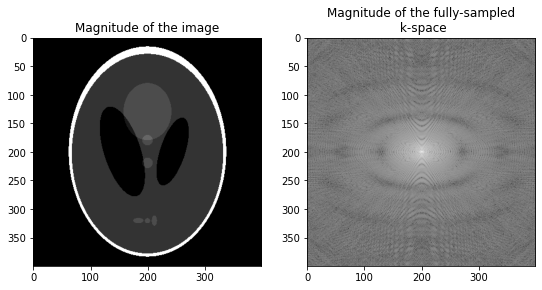

In [0]:
# let's load our data and see what it looks like
image = np.load('Tutorials/shepp_logan.npy')
# we add a batch and a channel dimension because the ops need it tow work correctly
# indeed in tf, the images are usually in the shape NHWC
# we also need it in complex dtype
image = image.astype(np.complex64)[None, ..., None]
image = tf.convert_to_tensor(image)
kspace = tf_fft(image)


subplot(121)
imshow(np.squeeze(tf.abs(image)))
title('Magnitude of the image')
subplot(122)
imshow(np.log10(np.squeeze(tf.abs(kspace))))
title('Magnitude of the fully-sampled\n k-space')

A naive solution is to take the inverse fourier transform of the sampled coefficients, with non-sampled coefficients filled to 0. The solution is then called the zero-filled solution.

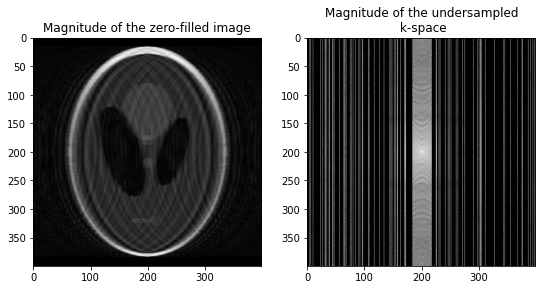

In [0]:
# we are going to accelerate the MRI acquisition by a factor 2
mask = gen_mask_tf(kspace[..., 0], accel_factor=4)
masked_kspace = _mask_tf([kspace, mask])
zero_filled_image = tf_ifft(masked_kspace)

subplot(121)
imshow(np.squeeze(tf.abs(zero_filled_image)))
title('Magnitude of the zero-filled image')

subplot(122)
imshow(np.log10(np.squeeze(tf.abs(masked_kspace)) + 1e-5))
title('Magnitude of the undersampled\n k-space');

## The classical iterative reconstruction

As you can see, the image is strongly aliased. We need a better solution.

For that, we will need to solve an optimisation problem with a data-consistency term and a regularisation term:
$$
argmin_{x \in \mathbb{R}^n} \frac12 \|F_{\Omega} x - y\|_2^2 + \lambda \|x\|_{TV} 
$$

In [0]:
# let's write that in tf
x = tf.Variable(tf.abs(zero_filled_image), trainable=True, name='x')
lamb = tf.constant(2e-2)

@tf.function
def loss():
  data_fidelity = tf.nn.l2_loss(tf.abs(tf_masked_fft([tf.cast(x, tf.complex64), mask]) - kspace))
  regularisation = tf.image.total_variation(x)
  return data_fidelity + lamb * regularisation

loss()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1039.7075], dtype=float32)>

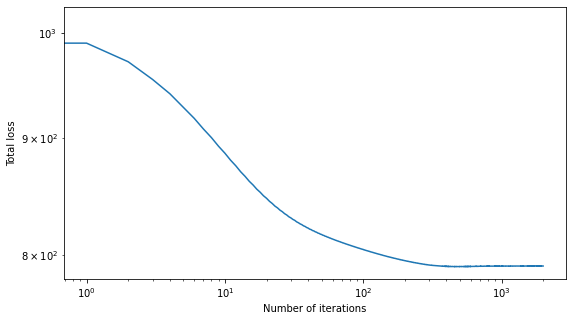

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2)

n_iter = 2000
verbose = 0
losses = []
for i_iter in tqdm(range(n_iter)):
    optimizer.minimize(loss, [x])
    losses.append(loss())
    if verbose > 0 and i_iter % 10 == 0:
        print(i_iter, loss())

loglog(losses)
xlabel('Number of iterations')
ylabel('Total loss');

Text(0.5, 1.0, 'Magnitude of the solution')

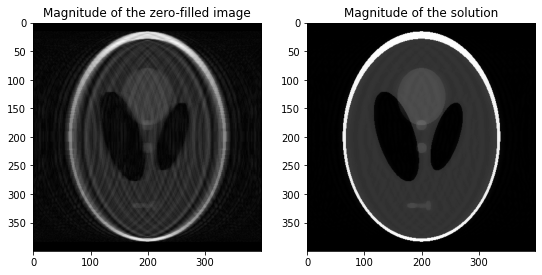

In [0]:
subplot(121)
imshow(np.squeeze(tf.abs(zero_filled_image)))
title('Magnitude of the zero-filled image')
subplot(122)
imshow(np.squeeze(np.abs(x)))
title('Magnitude of the solution')

### Quantitative metrics (for the magnitude)

In [0]:
print(
    'Zero-filled PSNR: ',
    np.squeeze(tf.image.psnr(tf.abs(image), tf.abs(zero_filled_image), 1.0)),
)
print(
    'Solution PSNR: ',
    np.squeeze(tf.image.psnr(tf.abs(image), tf.abs(x), 1.0)),
)

Zero-filled PSNR:  20.640238
Solution PSNR:  39.284195


In [0]:
print(
    'Zero-filled SSIM: ',
    np.squeeze(tf.image.ssim(tf.abs(image), tf.abs(zero_filled_image), 1.0)),
)
print(
    'Solution SSIM: ',
    np.squeeze(tf.image.ssim(tf.abs(image), tf.abs(x), 1.0)),
)

Zero-filled SSIM:  0.32820687
Solution SSIM:  0.90067923


## The Deep Learning approach

### The model

In [0]:
# an example of the subclassed API, written in OO style
# you also have sequential and functionnal APIs
class ResCNN(Model):
    def __init__(self, n_convs=4, n_filters=8, **kwargs):
        super(ResCNN, self).__init__(**kwargs)
        self.n_convs = n_convs
        self.n_filters = n_filters
        self.convs = [
            Conv2D(n_filters, 3, padding='same', activation='relu')
            for _ in range(n_convs-1)
        ]
        # important to have the last activation linear (i.e. no non-linearity) because 
        # otherwise you can't learn correctly.
        self.convs.append(Conv2D(1, 3, padding='same', activation='linear'))
        
    def call(self, inputs):
        # very simple trick, we could imagine sophisticated complex-valued non-linearity
        res_image = inputs
        for conv in self.convs:
            res_image = conv(res_image)
        reconstructed_image = inputs - res_image
        return reconstructed_image

### The data

In [0]:
def generate_random_shapes(size, n_shapes):
    while True:
        image, _ = random_shapes(
            (size, size),
            max_shapes=n_shapes,
            multichannel=False,
            allow_overlap=True,
            max_size=size,
            shape='ellipse'
        )
        # we need to inverse because in the Shepp Logan, the background is black
        yield 255 - image

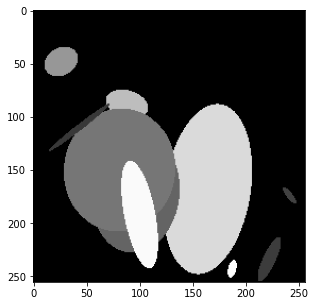

In [0]:
example_training_image = next(generate_random_shapes(256, 20))
plt.figure()
plt.imshow(example_training_image)

In [0]:
batch_size = 8

def from_image_to_training_example(image):
    image = tf.cast(image[None, ...], tf.complex64)
    # we need to normalize images for NNs to work best
    image = image / 255
    mask = gen_mask_tf(image, accel_factor=4)
    image = image[..., None]
    kspace = tf_masked_fft([image, mask])
    zero_filled_image = tf_ifft(kspace)
    zero_filled_image = tf.abs(zero_filled_image[0]) - 0.5
    image = tf.abs(image[0]) - 0.5
    return zero_filled_image, image
    

image_dataset = tf.data.Dataset.from_generator(
    generate_random_shapes, 
    tf.float32, 
    output_shapes=(256, 256), 
    args=(256, 20),
)

zero_filled_image_dataset = image_dataset.map(
    from_image_to_training_example,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).repeat().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

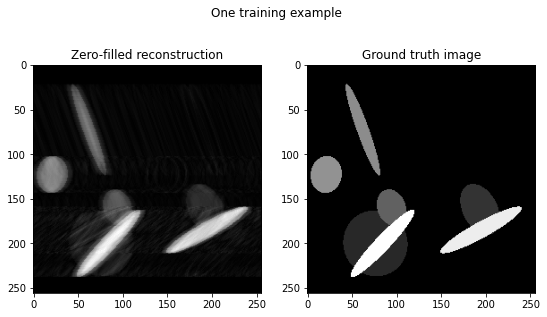

In [0]:
zero_filled_image_train, image_train = next(iter(zero_filled_image_dataset))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(zero_filled_image_train[0]))
axs[0].set_title('Zero-filled reconstruction')
axs[1].imshow(np.squeeze(image_train[0]))
axs[1].set_title('Ground truth image')
fig.suptitle('One training example');

### The training

In [0]:
# metrics
def tf_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

def tf_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

In [0]:
from_save = True

In [0]:
model = ResCNN(n_filters=32, n_convs=10)
# here depending on the solution you want, you could change the loss function
# for example to ssim
model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[tf_psnr, tf_ssim])
if from_save:
    model.load_weights('Tutorials/checkpoints/mri_recon_tuto')
else:
  model.fit(
      zero_filled_image_dataset,
      epochs=20,
      steps_per_epoch=200,
      verbose=1,
      validation_data=zero_filled_image_dataset,  # we can have the same generator since it's purely random
      validation_steps=1,
  )

### The evaluation

Text(0.5, 1.0, 'Magnitude of the solution')

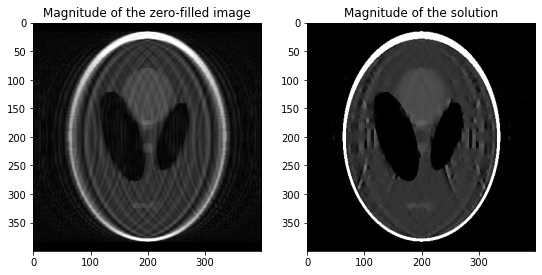

In [0]:
# qualitative
reconstructed_image_dl = model.predict(tf.abs(zero_filled_image) - 0.5) + 0.5

fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(zero_filled_image)), vmin=0, vmax=1)
axs[0].set_title('Magnitude of the zero-filled image')
axs[1].imshow(np.squeeze(reconstructed_image_dl), vmin=0, vmax=1)
axs[1].set_title('Magnitude of the solution')

In [0]:
model.evaluate(tf.abs(zero_filled_image) - 0.5, tf.abs(image) - 0.5)

1/1 [==============================] - 0s 1ms/step - loss: 0.0010 - tf_psnr: 29.9884 - tf_ssim: 0.8850


[0.0010026830714195967, 29.98836326599121, 0.8850430250167847]

In [0]:
model.evaluate(zero_filled_image_dataset, steps=1)

1/1 [==============================] - 0s 1ms/step - loss: 1.5840e-04 - tf_psnr: 39.3263 - tf_ssim: 0.9766


[0.00015840154082980007, 39.32632827758789, 0.9765810966491699]

### Save the model

In [0]:
model.save_weights('checkpoints/mri_recon_tuto')

!zip -r checkpoints.zip checkpoints

from google.colab import files
files.download('checkpoints.zip')